In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import math


In [28]:
# Simple distance-weight function where the weight is given by inverse of the square distance between two neurons
def distance_to_weight(d: torch.Tensor) -> torch.Tensor:
    return d**-1


# ReLU activation function between hidden layers
def activation(x: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.relu(x)


In [29]:
# 2D, fixed-x (forward-fixed), base example

spacer = 0.6  # space between layers on x-axis


class PCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.p0 = nn.Parameter(torch.tensor([[spacer * 0, 0]]).float())
        self.p1 = nn.Parameter(
            torch.tensor([[spacer * 1, 0.3], [spacer * 1, -0.3]]).float()
        )
        self.p2 = nn.Parameter(
            torch.tensor([[spacer * 2, 0.3], [spacer * 2, -0.3]]).float()
        )
        self.p3 = nn.Parameter(torch.tensor([[spacer * 3, 0]]).float())

        self.layers = [self.p0, self.p1, self.p2, self.p3]

    def forward(self, x):
        z = x

        D1 = torch.cdist(self.p0, self.p1)
        D1.retain_grad()
        W1 = distance_to_weight(D1)
        W1.retain_grad()
        z = activation(z @ W1)

        D2 = torch.cdist(self.p1, self.p2)
        D2.retain_grad()
        W2 = distance_to_weight(D2)
        W2.retain_grad()
        z = activation(z @ W2)

        D3 = torch.cdist(self.p2, self.p3)
        D3.retain_grad()
        W3 = distance_to_weight(D3)
        W3.retain_grad()
        z = activation(z @ W3)

        # For auto-grad analysis purposes, store D2, W2, D3, W3
        self.D1, self.W1, self.D2, self.W2, self.D3, self.W3 = D1, W1, D2, W2, D3, W3

        return z


model = PCN()


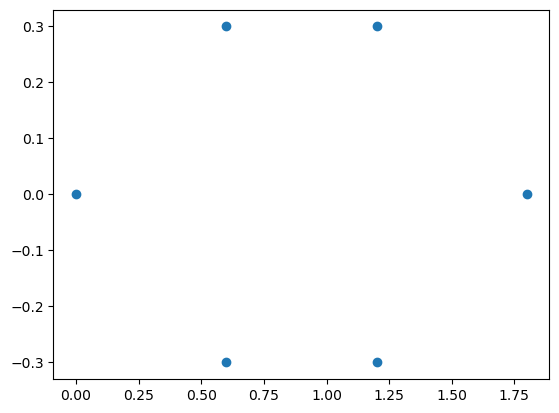

In [30]:
points = torch.cat([l.detach() for i, l in enumerate(model.layers)])

plt.scatter([p[0] for p in points], [p[1] for p in points])
plt.show()


In [31]:
x = torch.tensor([[1]]).float()
y = torch.tensor([[2]]).float()
pred = model(x)

loss = nn.MSELoss()
l = loss(pred, y)
l.backward()


In [32]:
force1 = model.D2.grad[0, 0]
force2 = model.D2.grad[1, 0]
force3 = model.D3.grad[1]

delta1 = model.p1[0] - model.p2[0]
delta2 = model.p1[1] - model.p2[0]
delta3 = model.p2[0] - model.p3[0]

angle1 = math.atan2(delta1[1], delta1[0])
angle2 = math.atan2(delta2[1], delta2[0])
angle3 = math.atan2(delta3[1], delta3[0])

fx1, fy1 = force1 * math.cos(angle1), force1 * math.sin(angle1)
fx2, fy2 = force2 * math.cos(angle2), force2 * math.sin(angle2)
fx3, fy3 = force3 * math.cos(angle3), force3 * math.sin(angle3)


In [33]:
print(f"forces: {-(fx1 + fx2) + fx3, -(fy1 + fy2) + fy3}")
print(f"point gradient: {model.p2.grad[0]}")


forces: (tensor([-0.0060]), tensor([0.3232]))
point gradient: tensor([-0.0060,  0.3232])


If we consider the gradient on the distance vector between each point as a force, then we can get the $x$ & $y$ force acting on each point by using the angle between the points. We then see here that the gradient that torch auto-grad gives us is given by the sum of the forces acting on each point. For future use, we should divide the grad of each point by the number of forces acting on it, in order to maintain a stable variance/learning rate throughout the network, regardless of the # of neurons at each layer. If $N_i$ is the # of neurons in the i'th layer, then the # of forces acting on a neuron in the i'th layer is given by $$N_{i-1} + N{i+1}$$


In [8]:
# TODO: low gpu space taken in both eval & train
